In [1]:
%matplotlib inline

# Efficiency of scattering transform in feature extraction

- Chuming DAI <cdaiab@connect.ust.hk> (contributed on coding, literature review, and analysis),
- Qing DU <q.du@connect.ust.hk> (contributed on coding, literature review, and analysis), and
- Jiahao HE <jhebe@connect.ust.hk> (contributed on coding, literature review, and analysis)

\* *in alphabetical order of surnames*

In this notebook, we would like to study the efficiency and robustness of feature extraction from hand-written digits by scattering transform with known invariance, compared to that done by pre-trained deep neural networks. We present transfer-learning methods performed on the MNIST dataset, which consists of 
- feature extraction using scattering network, ResNet-18, and VGG19, and
- classification on extracted features using random forest classifier.

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from scatwave.scattering import Scattering
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap,MDS,TSNE,LocallyLinearEmbedding,SpectralEmbedding
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from time import time
from os import listdir

seed = 42

use_gpu = torch.cuda.is_available()
bsize = 100
use_gpu

True

Firstly, we read the MNIST dataset from Pytorch datasets. Codes are refered from the Pytorch tutorials.

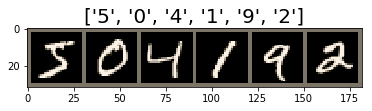

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

data = {'train': torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform),
        'test': torchvision.datasets.MNIST(root='./mnist', train=False,
                                       download=True, transform=transform)
       }

dataloaders = {x: torch.utils.data.DataLoader(data[x], batch_size=bsize)
               for x in ['train', 'test']
              }

dataiter = {x: iter(dataloaders[x])
           for x in ['train', 'test']
           }
class_names = ['%s' % i for i in range(10)]

def imshow(inp, title=None):
    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title, fontsize=20)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
n_show = 6
out = torchvision.utils.make_grid(inputs[:n_show])

imshow(out, title=[class_names[x] for x in classes[:n_show]])

## Feature extraction

### Scattering transformation
The scattering transformation function we used is from the [PyScatWave](https://github.com/edouardoyallon/pyscatwave) package developed by Eugene Belilovsky, Edouard Oyallon and Sergey Zagoruyko,  with highly efficient GPU implementation. According to their paper [*Scaling the Scattering Transform: Deep Hybrid Networks*](https://arxiv.org/abs/1703.08961), the defined scattering transformation is invariant to translations and rotations. We chose the scale of the averaging filter window to be $2^J=8$.

In [9]:
# Define scattering transform
scat = Scattering(M=28, N=28, J=3, pre_pad=True, jit=True).cuda()

# Perform scattering transform on datasets and save to file
features_train=[]
features_val=[]
classes_train=[]
classes_val=[]

start = time()
for data in ['train','test']:
    for i,(inputs,labels) in enumerate(dataloaders[data]):
        
        # Pre-pad images to 40*40 so that the image size is a multiple of the filters' size
        horizontal = np.zeros([6,28])
        vertical = np.zeros([40,6])
        inputs = inputs.numpy()
        new_inputs = np.array([])
        for ele in range(bsize):
            a = np.concatenate([horizontal, inputs[ele][0], horizontal], axis=0)
            new_inputs = np.append(new_inputs, np.concatenate([vertical, a, vertical], axis=1))
            
        inputs = torch.from_numpy(new_inputs.reshape([100,40,40])).unsqueeze(1)
        labels = labels.type(torch.LongTensor)
        inputs = inputs.type(torch.FloatTensor).cuda()
        out = scat(inputs).view(-1, 217*3*3).cpu().numpy()
        labels=labels.numpy()
        if data=='train':
            features_train.append(out)
            classes_train.append(labels)
        else:
            features_val.append(out)
            classes_val.append(labels)
print('Time used: %s seconds' % (time() - start))

np.save('scatt/features_train', np.vstack(features_train))
np.save('scatt/classes_train', np.hstack(classes_train))
np.save('scatt/features_val', np.vstack(features_val))
np.save('scatt/classes_val', np.hstack(classes_val))

print('train features size:{}\tlabels size:{}'.format(np.vstack(features_train).shape,np.hstack(classes_train).shape))
print('test features size:{}\tlabels size:{}'.format(np.vstack(features_val).shape,np.hstack(classes_val).shape))

/home/qdu/miniProject/scatwave/scattering.py:35: RuntimeWarning: Make sure you padded the input before to feed it!
  self._prepare_padding_size([1, 1, M, N])
/home/qdu/miniProject/scatwave/scattering.py:78: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  output.narrow(output.ndimension()-1, 0, 1).copy_(input)


0-100-8-40-40-periodize.cu
modulus.cu
0-100-2-40-40-periodize.cu
0-100-4-20-20-periodize.cu
0-100-4-40-40-periodize.cu
0-100-2-10-10-periodize.cu
0-100-2-20-20-periodize.cu
Time used: 58.096208333969116 seconds
train features size:(60000, 1953)	labels size:(60000,)
test features size:(10000, 1953)	labels size:(10000,)


### Pre-trained neural networks
We used the pre-trained ResNet-18 and VGG19 embedded in the Pytorch package.

In [11]:
def extract_features(root, gpu_device=0):
    features_train=[]
    features_val=[]
    classes_train=[]
    classes_val=[]
    
    # Import pre-trained networks
    if root == 'resnet':
        model = torchvision.models.resnet18(pretrained = True).cuda(gpu_device)
        modules = list(model.children())[:-1]
        reshape = (-1,512)
    elif root == 'vgg19':
        model = torchvision.models.vgg19(pretrained = True).cuda(gpu_device)
        reshape = (-1, 7*7*512)
    modules = list(model.children())[:-1]
    model_features = nn.Sequential(*modules)
    
    # Extract features
    start = time()
    for data in ['train','test']:
        for i,(inputs,labels) in enumerate(dataloaders[data]):
            # Expand the image size to from 1*28*28 to 3*224*224
            inputs = torch.from_numpy(np.kron(inputs.numpy(),np.ones((8,8)))).expand(bsize,3,224,224)
            
            labels = labels.type(torch.LongTensor)
            inputs = inputs.type(torch.FloatTensor)
            out=model_features.forward(Variable(inputs).cuda(gpu_device))
            out=out.view(*reshape).cpu().data.numpy()
            labels=labels.numpy()
            if data=='train':
                features_train.append(out)
                classes_train.append(labels)
            else:
                features_val.append(out)
                classes_val.append(labels)
    print("Time used: %s seconds" % (time() - start))
    features_train=np.vstack(features_train)
    classes_train=np.hstack(classes_train)
    features_val=np.vstack(features_val)
    classes_val=np.hstack(classes_val)

    np.save(root+'/features_train', features_train)
    np.save(root+'/classes_train', classes_train)
    np.save(root+'/features_val', features_val)
    np.save(root+'/classes_val', classes_val)

    print(root)
    print('train features size:{}\tlabels size:{}'.format(features_train.shape,classes_train.shape))
    print('test features size:{}\tlabels size:{}'.format(features_val.shape,classes_val.shape))

In [12]:
# Extract features using ResNet-18 and save to file
extract_features('resnet', gpu_device=1)

Time used: 139.65407705307007 seconds
resnet
train features size:(60000, 512)	labels size:(60000,)
test features size:(10000, 512)	labels size:(10000,)


In [14]:
# Extract features using VGG19 and save to file
extract_features('vgg19', gpu_device=2)

Time used: 309.60074973106384 seconds
vgg19
train features size:(60000, 25088)	labels size:(60000,)
test features size:(10000, 25088)	labels size:(10000,)


The scattering transform takes less computation time than the other two models (less than half of the time taken by ResNet-18, and is only 19% of the time taken by VGG-19). This shows that the shallow structure of the scattering net allows it to efficiently extract features from the image datasets.

### Visualization of the extracted features

We projected the extracted features from 600 data points on a two-dimentional plane, using PCA, Isomap, and TSNE.

vgg19
PCA starts......
Isomap starts......
TSNE starts......
resnet
PCA starts......
Isomap starts......
TSNE starts......
scatt
PCA starts......
Isomap starts......
TSNE starts......


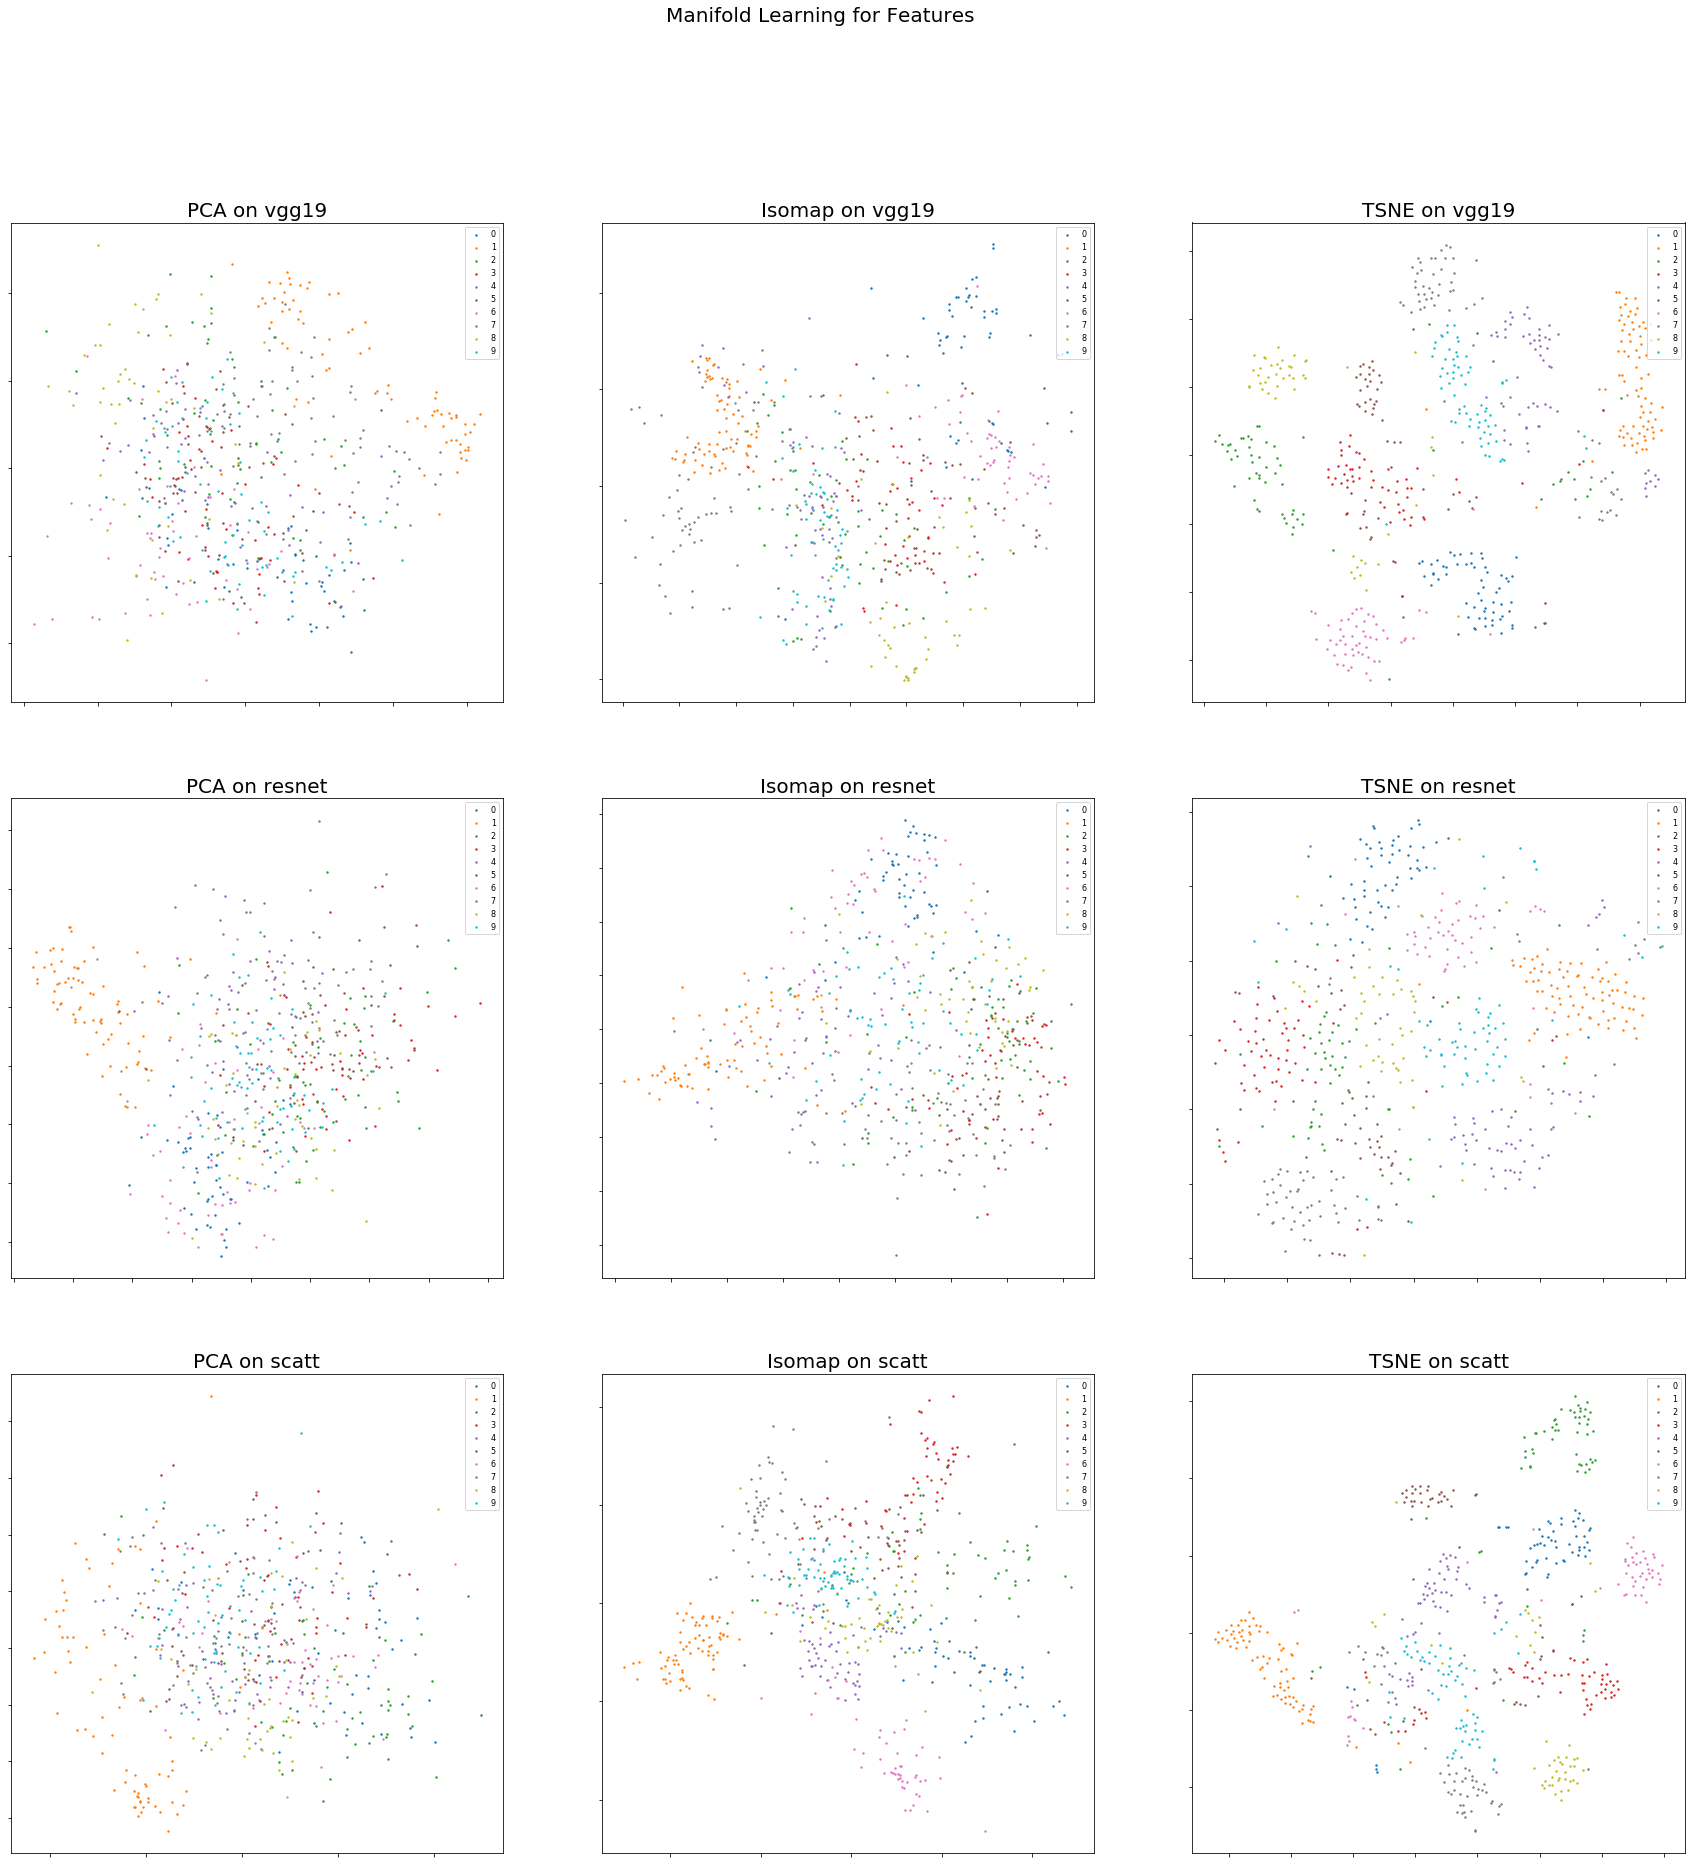

In [19]:
ntrain = 600
NN = ['vgg19', 'resnet', 'scatt']
methods=['PCA','Isomap', 'TSNE']
fig_features = plt.figure(1, figsize=(30,30))
fig_features.suptitle('Manifold Learning for Features', fontsize=20)
for k in range(len(NN)):
    print(NN[k])
    features_train = np.load(NN[k]+'/features_train.npy')[0:ntrain]
    classes_train = np.load(NN[k]+'/classes_train.npy')[0:ntrain]

    for i,method in enumerate(methods):
        print('{} starts......'.format(method))
        if method=='PCA':
            manifold=PCA(n_components=2)
        elif method=='TSNE':
            exec('manifold={}(n_components=2,init="pca")'.format(method))
        elif method=='MDS':
            manifold=MDS(n_init=1, max_iter=100)
        else:
            exec('manifold={}(n_neighbors=6)'.format(method))
            
        features_2D = manifold.fit_transform(features_train)
        ax=fig_features.add_subplot(331+i+k*len(NN))
        for s in range(10):
            ax.scatter(features_2D[np.where(classes_train==s),0],
                       features_2D[np.where(classes_train==s),1],
                       s=2,label='%d' % s)
        ax.legend(loc='upper right',prop={'size':8})
        ax.set_title(method + ' on ' + NN[k], fontsize=20)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

In this visualization, especially in the third column, we see that these features are well clustered by their intrinsic properties.

## Classification using traditional learning methods

### PCA + Random Forest Classification
As the features we obtained are high dimentional, we would like to use PCA to reduce dimentions. We performed a cross-validation on the accuracies of classifying the test sets to choose the dimension. We show the result in graphs with x-axis being the number of components, and y-axis being the explained variance of the selected components. A vertical dotted line is drawn on each graph indicating the number of components achieving the best accuracy in the classification.

In [3]:
def read_features(method):
    train = np.load(method+'/features_train.npy')
    train_labels = np.load(method+'/classes_train.npy')
    test = np.load(method+'/features_val.npy')
    test_labels = np.load(method+'/classes_val.npy')
    return train, test, train_labels, test_labels

train, test, train_labels, test_labels = read_features('scatt')

In [21]:
def pca_rf(method, interval=(20,100,10)):
    train, test, train_labels, test_labels = read_features(method)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed)
    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), ('rf', rf)])
    pca.fit(train)
    plt.figure(1, figsize=(10,5))
    plt.clf()
    plt.axes([.2, .2, .7, .7])
    plt.plot(pca.explained_variance_[:interval[1]], linewidth=2)
    plt.axis('tight')
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_')
    # Prediction
    n_components = range(*interval)

    estimator = GridSearchCV(pipe,
                             dict(pca__n_components=n_components),
                             scoring='accuracy', n_jobs=-1)
    estimator.fit(train, train_labels)

    plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='n_components chosen')
    plt.legend(prop=dict(size=12))
    plt.title(method)
    plt.show()

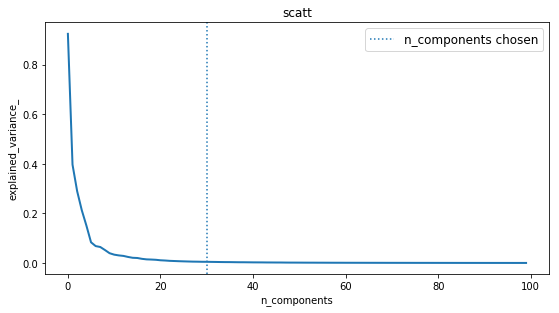

In [20]:
pca_rf('scatt', interval=(20, 100, 10))

The above graph shows that 30 components of the scattering coefficients gain the best accuracy for the random forest classifier.

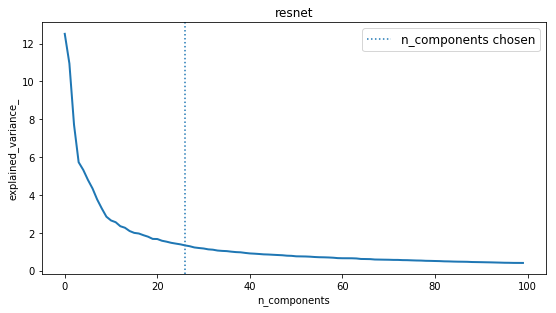

In [56]:
pca_rf('resnet', interval=(1,100,5))

The above graph shows that only around 25 components of the ResNet-18 features can achieve the best accuracy for the random forest classifier.

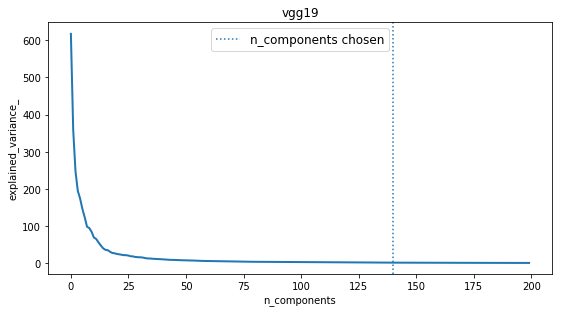

In [25]:
pca_rf('vgg19', interval=(20, 200, 20))

The above graph shows that 140 components achieves the best accuracy for the random forest classifier on VGG-19 features.

### Robustness
We further test the robustness of the features by evaluating the scores (classification accuracies) given by the classifier trained on different sizes of training set. 

In [61]:
sizes = [100, 300, 500, 1000, 5000, 10000, 30000, 60000]
def pca_rf_scores(method, n_components=None, model='all'):
    train, test, train_labels, test_labels = read_features(method)
    scores = []
    for size in sizes:
        rf = RandomForestClassifier(n_jobs=-1, random_state=seed)
        if n_components:
            pca = PCA(n_components=n_components)
            pipe = Pipeline(steps=[('pca', pca), ('rf', rf)])
        if model == 'all':
            model = pipe
        elif model == 'rf':
            model = rf
        model.fit(train[:size], train_labels[:size])
        scores.append(model.score(test, test_labels))
    return scores

In [63]:
pd.DataFrame(
    np.array([
        sizes, 
        pca_rf_scores('scatt', n_components=30), 
        pca_rf_scores('resnet', n_components=25), 
        pca_rf_scores('vgg19', n_components=140)
    ]).transpose(),columns=['size of training data', 'scatt', 'resnet', 'vgg19'])

,size of training data,scatt,resnet,vgg19
0,100.0,0.5390,0.4840,0.5131
1,300.0,0.7365,0.5888,0.6075
2,500.0,0.7887,0.6123,0.6539
3,1000.0,0.8236,0.6614,0.7496
4,5000.0,0.9037,0.7411,0.8625
5,10000.0,0.9196,0.7631,0.8875
6,30000.0,0.9448,0.7849,0.9154
7,60000.0,0.9537,0.8002,0.9302


The above table (1) shows the resulting test accuracies of different feature sets with the best number of components achieved above.

In [64]:
pd.DataFrame(
    np.array([
        sizes, 
        pca_rf_scores('scatt', model='rf'), 
        pca_rf_scores('resnet', model='rf'), 
        pca_rf_scores('vgg19', model='rf')
    ]).transpose(),columns=['size of training data', 'scatt', 'resnet', 'vgg19'])

,size of training data,scatt,resnet,vgg19
0,100.0,0.6796,0.3750,0.5867
1,300.0,0.7757,0.4603,0.7365
2,500.0,0.8313,0.5110,0.7722
3,1000.0,0.8829,0.5619,0.8337
4,5000.0,0.9323,0.6589,0.9090
5,10000.0,0.9481,0.6898,0.9198
6,30000.0,0.9636,0.7419,0.9411
7,60000.0,0.9657,0.7604,0.9518


The above table (2) shows the resulting test accuracies of different feature sets without PCA. In both tables, the results show that the scattering coefficients outperforms the features extracted from ResNet-18 and VGG19, especially when the size of training samples is small. The implication behind this result is that, the scattering transform's elimination of the variability caused by translation and small deformation plays a key role in successfully classifying hand-written digits. Even with limited knowledge of the images (small training set), the invariance nature of its structure allows it to preserve more information about the image than the other neural nets.

**Remaining quesion:**

Comparing table (1) and (2), ResNet-18 differs from the other two in the way that the accuracy without PCA decreases. What could be the reason behind this?